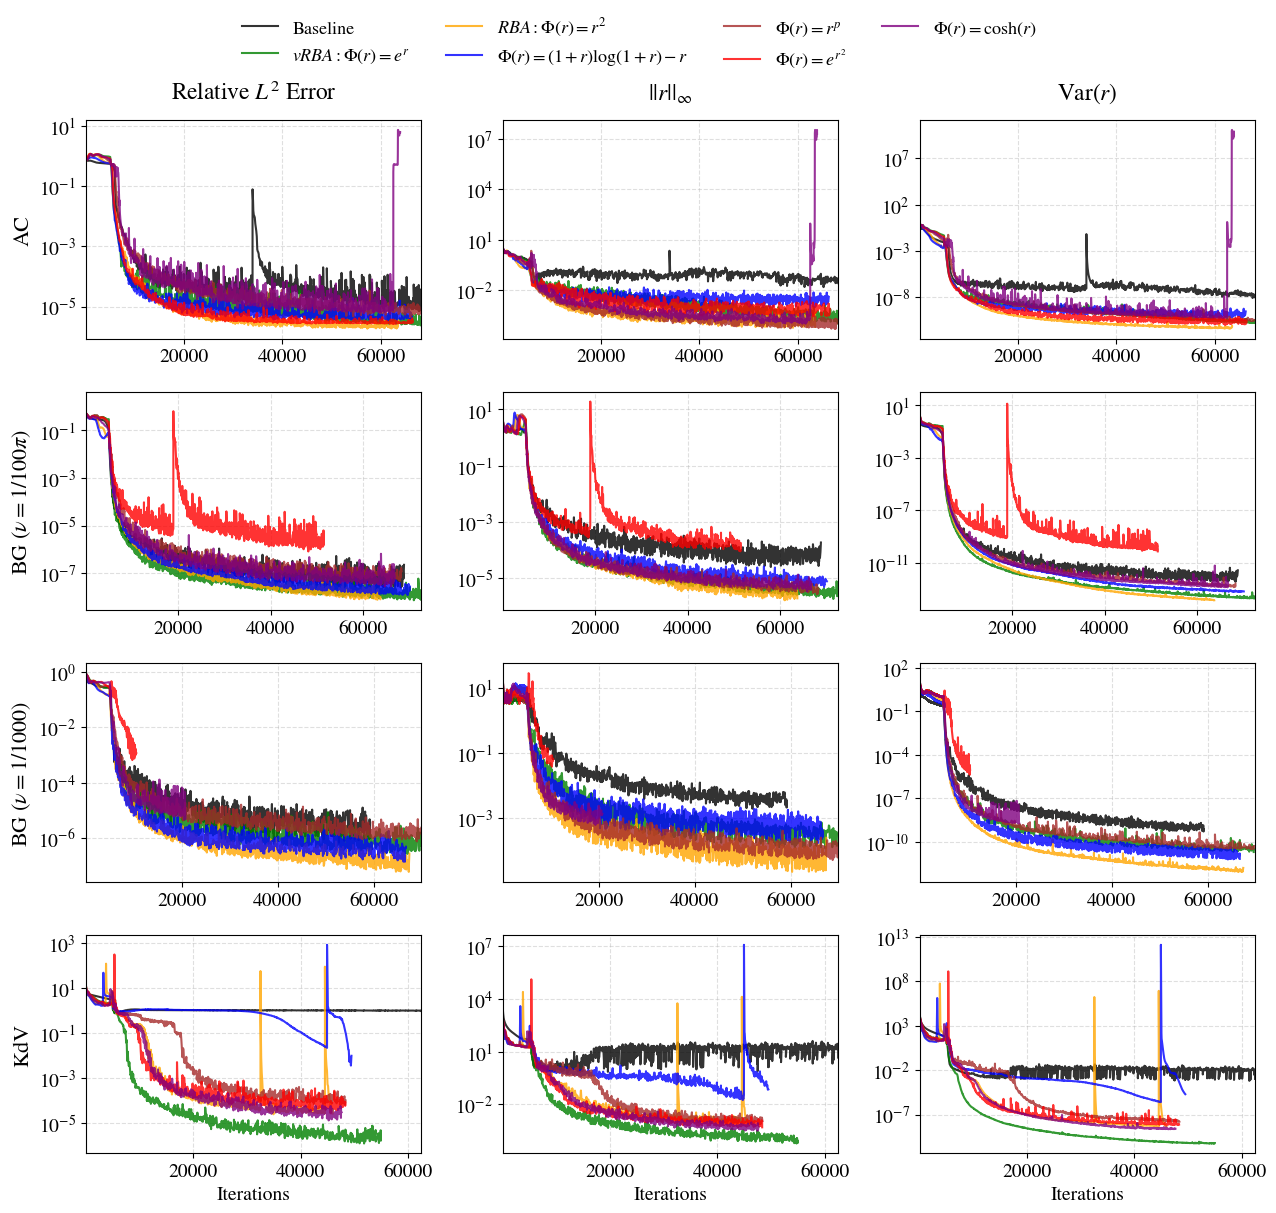

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
EPOCHS_ADAM = 5000  
DIVERGENCE_THRESHOLD = 1e999  # Mask values larger than this to prevent plot explosion

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

BASE_DIR = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'

EXAMPLES = {
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'AC'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/100\pi$)'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/1000$)'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}

ROW_ORDER = ['AC', 'BG_100pi', 'BG_1000', 'KdV']

# --- 3. Helper: Dense Iteration Reconstruction ---
def get_dense_iterations(data, epochs_adam=5000):
    if 'var_hist' not in data or 'all_its' not in data:
        return None
    
    var_hist = data['var_hist']
    saved_its = data['all_its']
    total_steps = len(var_hist)
    
    if total_steps > epochs_adam:
        iter_adam_dense = np.arange(1, epochs_adam + 1)
        num_ssb_steps = total_steps - epochs_adam
        if num_ssb_steps > 0:
            iter_ssb = saved_its[-num_ssb_steps:]
            return np.concatenate([iter_adam_dense, iter_ssb])
    
    return np.arange(1, total_steps + 1)

# --- 4. Data Loading Logic ---
def load_history(example_key, method):
    ex_config = EXAMPLES[example_key]
    path = os.path.join(BASE_DIR, ex_config['dir'], ex_config['file_fmt'].format(method))
    
    if not os.path.exists(path):
        return None

    try:
        data = np.load(path)
        keys = list(data.keys())
        
        iter_l2, iter_res = None, None
        l2, linf, var = None, None, None

        # --- CASE: BURGERS 1000 (Special Logic) ---
        if example_key == 'BG_1000':
            l2   = data['error_history'] if 'error_history' in keys else None
            linf = data['linf_hist']     if 'linf_hist' in keys else None
            var  = data['var_hist']      if 'var_hist' in keys else None
            
            if 'all_its' in keys: iter_l2 = data['all_its']
            iter_res = get_dense_iterations(data, EPOCHS_ADAM)
            
            if iter_l2 is None and l2 is not None: iter_l2 = np.arange(len(l2))

        # --- CASE: OTHERS (Standard Logic) ---
        else:
            if example_key == 'AC':
                l2   = data['error_history'] if 'error_history' in keys else None
                linf = data['linf_history']  if 'linf_history' in keys else None
                var  = data['var_history']   if 'var_history' in keys else None
                base_its = data['all_its']   if 'all_its' in keys else None

            elif example_key == 'BG_100pi':
                l2   = data['error_history'] if 'error_history' in keys else None
                linf = data['linf_hist']     if 'linf_hist' in keys else None
                var  = data['var_hist']      if 'var_hist' in keys else None
                base_its = data['all_its']   if 'all_its' in keys else None

            elif example_key == 'KdV':
                l2   = data['relative_l2_history']     if 'relative_l2_history' in keys else None
                linf = data['residual_linf_history']     if 'residual_linf_history' in keys else None
                var  = data['residual_variance_history'] if 'residual_variance_history' in keys else None
                base_its = data['iterations']            if 'iterations' in keys else None
            
            target_len = 0
            if l2 is not None: target_len = len(l2)
            elif var is not None: target_len = len(var)
            
            if base_its is not None and len(base_its) == target_len:
                iter_l2 = base_its
                iter_res = base_its
            else:
                gen_its = np.arange(target_len)
                iter_l2 = gen_its
                iter_res = gen_its

        return iter_l2, l2, iter_res, linf, var

    except Exception as e:
        print(f"Error loading {example_key}/{method}: {e}")
        return None

# --- 5. Plotting Routine ---
def create_comparison_plot():
    fig, axes = plt.subplots(4, 3, figsize=(13, 12), sharex='row')
    
    cols = [r'Relative $L^2$ Error', r'$||r||_\infty$', r'Var$(r)$']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, pad=15)

    for i, ex_key in enumerate(ROW_ORDER):
        row_axes = axes[i]
        example_name = EXAMPLES[ex_key]['name']
        
        # Row Label
        row_axes[0].set_ylabel(example_name, fontsize=16)

        max_iter_in_row = 10 

        for method in METHODS:
            if method not in STYLES: continue
            
            res = load_history(ex_key, method)
            if res is None: continue
            
            iter_l2, l2, iter_res, linf, var = res
            style = STYLES[method]

            # --- PLOT 1: L2 ERROR ---
            if l2 is not None and iter_l2 is not None:
                min_len = min(len(iter_l2), len(l2))
                x_vals = iter_l2[:min_len]
                y_vals = l2[:min_len].copy()
                
                # Update Max Iterations
                if len(x_vals) > 0: max_iter_in_row = max(max_iter_in_row, x_vals[-1])
                
                # Mask Divergence
                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan
                
                row_axes[0].plot(x_vals, y_vals, label=style['label'], 
                                 color=style['color'], linewidth=1.5, alpha=0.8)

            # --- PLOT 2: L-INFINITY ---
            if linf is not None and iter_res is not None:
                min_len = min(len(iter_res), len(linf))
                x_vals = iter_res[:min_len]
                y_vals = linf[:min_len].copy()
                
                if len(x_vals) > 0: max_iter_in_row = max(max_iter_in_row, x_vals[-1])
                
                # Mask Divergence
                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan

                row_axes[1].plot(x_vals, y_vals, color=style['color'], 
                                 linewidth=1.5, alpha=0.8)
            
            # --- PLOT 3: VARIANCE ---
            if var is not None and iter_res is not None:
                min_len = min(len(iter_res), len(var))
                x_vals = iter_res[:min_len]
                y_vals = var[:min_len].copy()
                
                # Mask Divergence
                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan

                row_axes[2].plot(x_vals, y_vals, color=style['color'], 
                                 linewidth=1.5, alpha=0.8)

        # Formatting per row
        for ax in row_axes:
            ax.set_yscale('log')
            ax.grid(True, which="both", ls="--", alpha=0.4)
            # Set X-Limits: 10 (1e1) to Max Iterations
            ax.set_xlim(left=10, right=max_iter_in_row)

    # X Labels
    for ax in axes[-1]:
        ax.set_xlabel('Iterations')

    # Legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=4, frameon=False, fontsize=13)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('Convergence_all.png')
    plt.show()

if __name__ == "__main__":
    create_comparison_plot()


                       PERFORMANCE REPORT (Smoothed Window=1)                        
Example    | Method       | L2 Error         | L-Infinity       | Variance        
-------------------------------------------------------------------------------------
AC         | linear       | 9.53e-06 (Final) | 2.61e-02 (Final) | 1.03e-08 (Final)
AC         | exponential  | 4.32e-06 (Final) | 1.45e-04 (Final) | 3.30e-11 (Final)
AC         | quadratic    | 3.14e-06 (Final) | 6.43e-05 (Final) | 7.43e-12 (Final)
AC         | logarithmic  | 4.77e-06 (Final) | 3.95e-03 (Final) | 2.96e-10 (Final)
AC         | lp           | 5.86e-06 (Final) | 1.54e-04 (Final) | 3.36e-11 (Final)
AC         | superexp     | 3.61e-06 (Final) | 3.83e-04 (Final) | 2.17e-11 (Final)
AC         | cosh         | 5.77e-06 (Best (Div)) | 1.01e-04 (Best (Div)) | 6.09e-11 (Best (Div))
BG_100pi   | linear       | 2.30e-07 (Final) | 1.82e-04 (Final) | 2.59e-12 (Final)
BG_100pi   | exponential  | 1.07e-08 (Final) | 2.47e-06 (Final) |

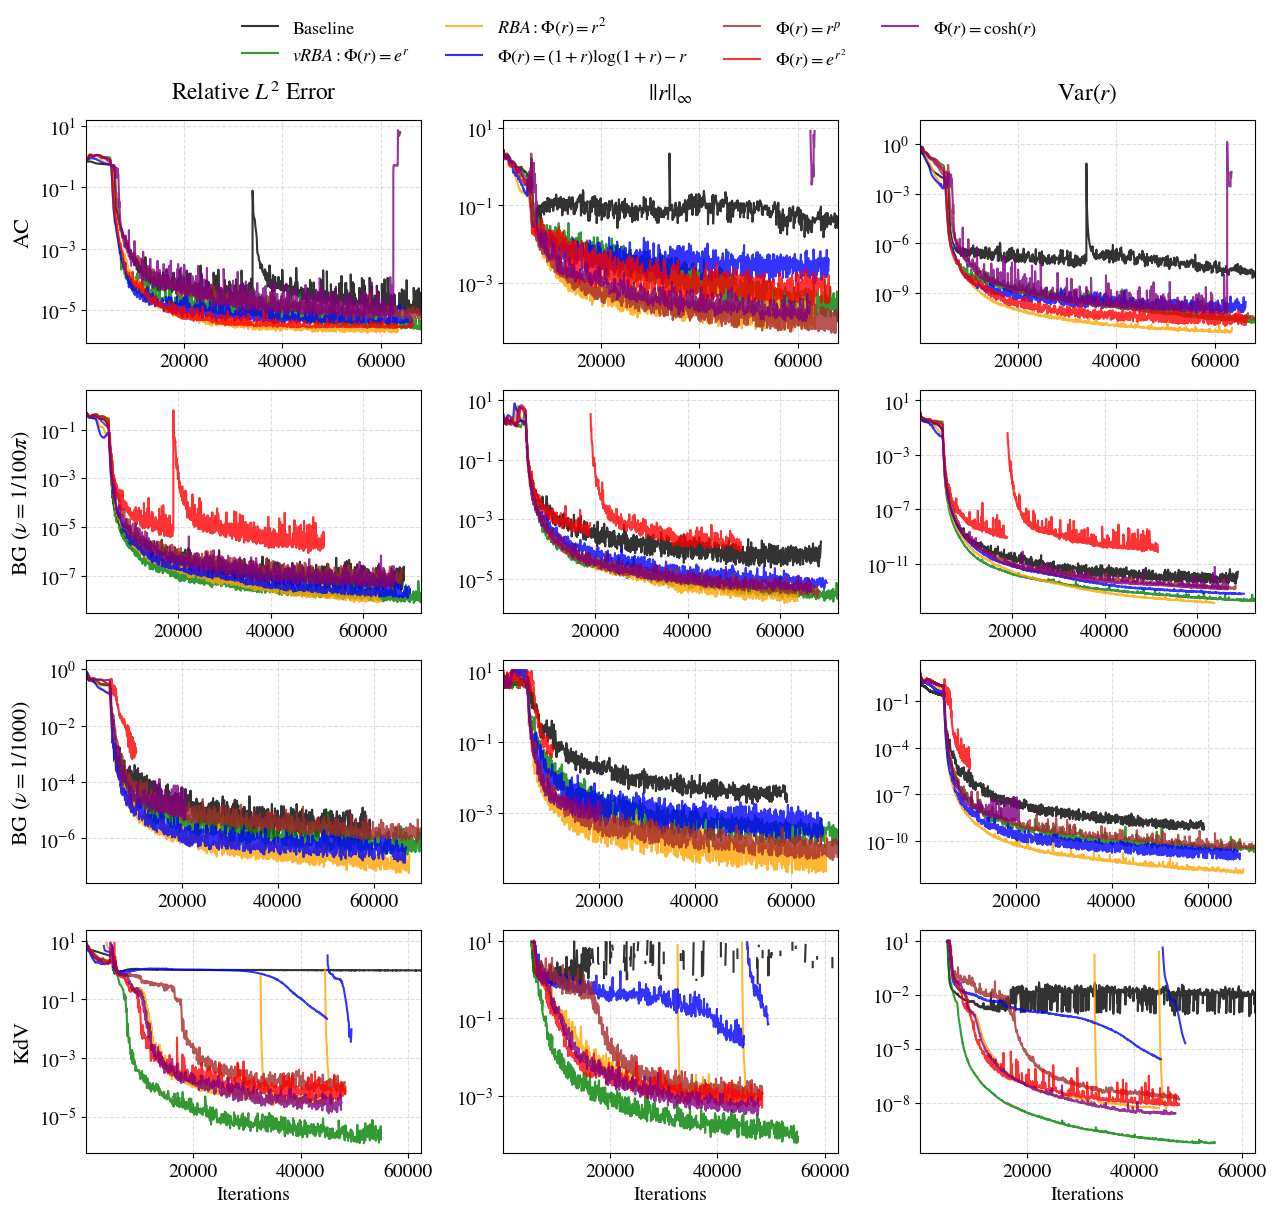

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
EPOCHS_ADAM = 5000  
DIVERGENCE_THRESHOLD = 10
SMOOTHING_WINDOW = 1
REPORT_THRESHOLD = 1  # Threshold to switch from 'Final' to 'Best'

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

BASE_DIR = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'

EXAMPLES = {
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'AC'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/100\pi$)'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/1000$)'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}

ROW_ORDER = ['AC', 'BG_100pi', 'BG_1000', 'KdV']

# --- 3. Helpers ---
def get_dense_iterations(data, epochs_adam=5000):
    if 'var_hist' not in data or 'all_its' not in data:
        return None
    var_hist = data['var_hist']
    saved_its = data['all_its']
    total_steps = len(var_hist)
    if total_steps > epochs_adam:
        iter_adam_dense = np.arange(1, epochs_adam + 1)
        num_ssb_steps = total_steps - epochs_adam
        if num_ssb_steps > 0:
            iter_ssb = saved_its[-num_ssb_steps:]
            return np.concatenate([iter_adam_dense, iter_ssb])
    return np.arange(1, total_steps + 1)

def smooth_data(y, x, window_size):
    if len(y) < window_size:
        return y, x
    kernel = np.ones(window_size) / window_size
    y_smooth = np.convolve(y, kernel, mode='valid')
    x_trimmed = x[window_size - 1:]
    return y_smooth, x_trimmed

def get_fair_metric(y_smooth):
    """
    Returns the final value unless it exceeds threshold, 
    in which case it returns the minimum value (best achieved).
    """
    if len(y_smooth) == 0: return np.nan, "N/A"
    
    final_val = y_smooth[-1]
    
    if final_val > REPORT_THRESHOLD:
        best_val = np.min(y_smooth)
        return best_val, "Best (Div)"
    else:
        return final_val, "Final"

# --- 4. Data Loading Logic ---
def load_history(example_key, method):
    ex_config = EXAMPLES[example_key]
    path = os.path.join(BASE_DIR, ex_config['dir'], ex_config['file_fmt'].format(method))
    if not os.path.exists(path): return None

    try:
        data = np.load(path)
        keys = list(data.keys())
        iter_l2, iter_res = None, None
        l2, linf, var = None, None, None

        if example_key == 'BG_1000':
            l2   = data['error_history'] if 'error_history' in keys else None
            linf = data['linf_hist']     if 'linf_hist' in keys else None
            var  = data['var_hist']      if 'var_hist' in keys else None
            if 'all_its' in keys: iter_l2 = data['all_its']
            iter_res = get_dense_iterations(data, EPOCHS_ADAM)
            if iter_l2 is None and l2 is not None: iter_l2 = np.arange(len(l2))
        else:
            if example_key == 'AC':
                l2   = data['error_history'] if 'error_history' in keys else None
                linf = data['linf_history']  if 'linf_history' in keys else None
                var  = data['var_history']   if 'var_history' in keys else None
                base_its = data['all_its']   if 'all_its' in keys else None
            elif example_key == 'BG_100pi':
                l2   = data['error_history'] if 'error_history' in keys else None
                linf = data['linf_hist']     if 'linf_hist' in keys else None
                var  = data['var_hist']      if 'var_hist' in keys else None
                base_its = data['all_its']   if 'all_its' in keys else None
            elif example_key == 'KdV':
                l2   = data['relative_l2_history']     if 'relative_l2_history' in keys else None
                linf = data['residual_linf_history']     if 'residual_linf_history' in keys else None
                var  = data['residual_variance_history'] if 'residual_variance_history' in keys else None
                base_its = data['iterations']            if 'iterations' in keys else None
            
            target_len = 0
            if l2 is not None: target_len = len(l2)
            elif var is not None: target_len = len(var)
            
            if base_its is not None and len(base_its) == target_len:
                iter_l2 = base_its; iter_res = base_its
            else:
                gen_its = np.arange(target_len)
                iter_l2 = gen_its; iter_res = gen_its

        return iter_l2, l2, iter_res, linf, var
    except Exception as e:
        print(f"Error loading {example_key}/{method}: {e}")
        return None

# --- 5. Main Routine ---
def main():
    fig, axes = plt.subplots(4, 3, figsize=(13, 12), sharex='row')
    
    cols = [r'Relative $L^2$ Error', r'$||r||_\infty$', r'Var$(r)$']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, pad=15)

    # Dictionary to store report data
    report_list = []

    for i, ex_key in enumerate(ROW_ORDER):
        row_axes = axes[i]
        example_name = EXAMPLES[ex_key]['name']
        row_axes[0].set_ylabel(example_name, fontsize=16)

        max_iter_in_row = 10 

        for method in METHODS:
            if method not in STYLES: continue
            
            res = load_history(ex_key, method)
            if res is None: continue
            
            iter_l2, l2, iter_res, linf, var = res
            style = STYLES[method]
            
            # Placeholders for report
            val_l2, type_l2 = np.nan, "-"
            val_linf, type_linf = np.nan, "-"
            val_var, type_var = np.nan, "-"

            # --- PLOT 1: L2 ERROR ---
            if l2 is not None and iter_l2 is not None:
                min_len = min(len(iter_l2), len(l2))
                x_vals = iter_l2[:min_len]
                y_vals = l2[:min_len].copy()
                
                y_vals, x_vals = smooth_data(y_vals, x_vals, SMOOTHING_WINDOW)
                val_l2, type_l2 = get_fair_metric(y_vals)  # Capture Metric

                if len(x_vals) > 0: max_iter_in_row = max(max_iter_in_row, x_vals[-1])
                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan
                row_axes[0].plot(x_vals, y_vals, label=style['label'], 
                                 color=style['color'], linewidth=1.5, alpha=0.8)

            # --- PLOT 2: L-INFINITY ---
            if linf is not None and iter_res is not None:
                min_len = min(len(iter_res), len(linf))
                x_vals = iter_res[:min_len]
                y_vals = linf[:min_len].copy()
                
                y_vals, x_vals = smooth_data(y_vals, x_vals, SMOOTHING_WINDOW)
                val_linf, type_linf = get_fair_metric(y_vals) # Capture Metric

                if len(x_vals) > 0: max_iter_in_row = max(max_iter_in_row, x_vals[-1])
                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan
                row_axes[1].plot(x_vals, y_vals, color=style['color'], 
                                 linewidth=1.5, alpha=0.8)
            
            # --- PLOT 3: VARIANCE ---
            if var is not None and iter_res is not None:
                min_len = min(len(iter_res), len(var))
                x_vals = iter_res[:min_len]
                y_vals = var[:min_len].copy()
                
                y_vals, x_vals = smooth_data(y_vals, x_vals, SMOOTHING_WINDOW)
                val_var, type_var = get_fair_metric(y_vals) # Capture Metric

                y_vals[y_vals > DIVERGENCE_THRESHOLD] = np.nan
                row_axes[2].plot(x_vals, y_vals, color=style['color'], 
                                 linewidth=1.5, alpha=0.8)

            # Append to report list
            report_list.append({
                'Example': ex_key,
                'Method': method,
                'L2 (val)': val_l2, 'L2 (type)': type_l2,
                'Linf (val)': val_linf, 'Linf (type)': type_linf,
                'Var (val)': val_var, 'Var (type)': type_var
            })

        for ax in row_axes:
            ax.set_yscale('log')
            ax.grid(True, which="both", ls="--", alpha=0.4)
            ax.set_xlim(left=10, right=max_iter_in_row)

    for ax in axes[-1]:
        ax.set_xlabel('Iterations')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=4, frameon=False, fontsize=13)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('Convergence_all.png')
    
    # --- PRINT REPORT ---
    print("\n" + "="*85)
    print(f"{'PERFORMANCE REPORT (Smoothed Window=' + str(SMOOTHING_WINDOW) + ')':^85}")
    print("="*85)
    print(f"{'Example':<10} | {'Method':<12} | {'L2 Error':<16} | {'L-Infinity':<16} | {'Variance':<16}")
    print("-" * 85)
    
    for r in report_list:
        # Format strings: 1.23e-04 (Final)
        l2_str = f"{r['L2 (val)']:.2e} ({r['L2 (type)']})"
        linf_str = f"{r['Linf (val)']:.2e} ({r['Linf (type)']})"
        var_str = f"{r['Var (val)']:.2e} ({r['Var (type)']})"
        
        print(f"{r['Example']:<10} | {r['Method']:<12} | {l2_str:<16} | {linf_str:<16} | {var_str:<16}")
    print("="*85 + "\n")

    plt.show()

if __name__ == "__main__":
    main()


--- Analyzing AC ---
Baseline L2: 8.97e-06
Winner: quadratic (L2: 1.88e-06)

--- Analyzing BG_100pi ---
Baseline L2: 2.78e-08
Winner: quadratic (L2: 8.25e-09)

--- Analyzing BG_1000 ---
Baseline L2: 1.76e-06
Winner: quadratic (L2: 2.68e-07)

--- Analyzing KdV ---
Baseline L2: 9.46e-01
Winner: exponential (L2: 2.17e-06)


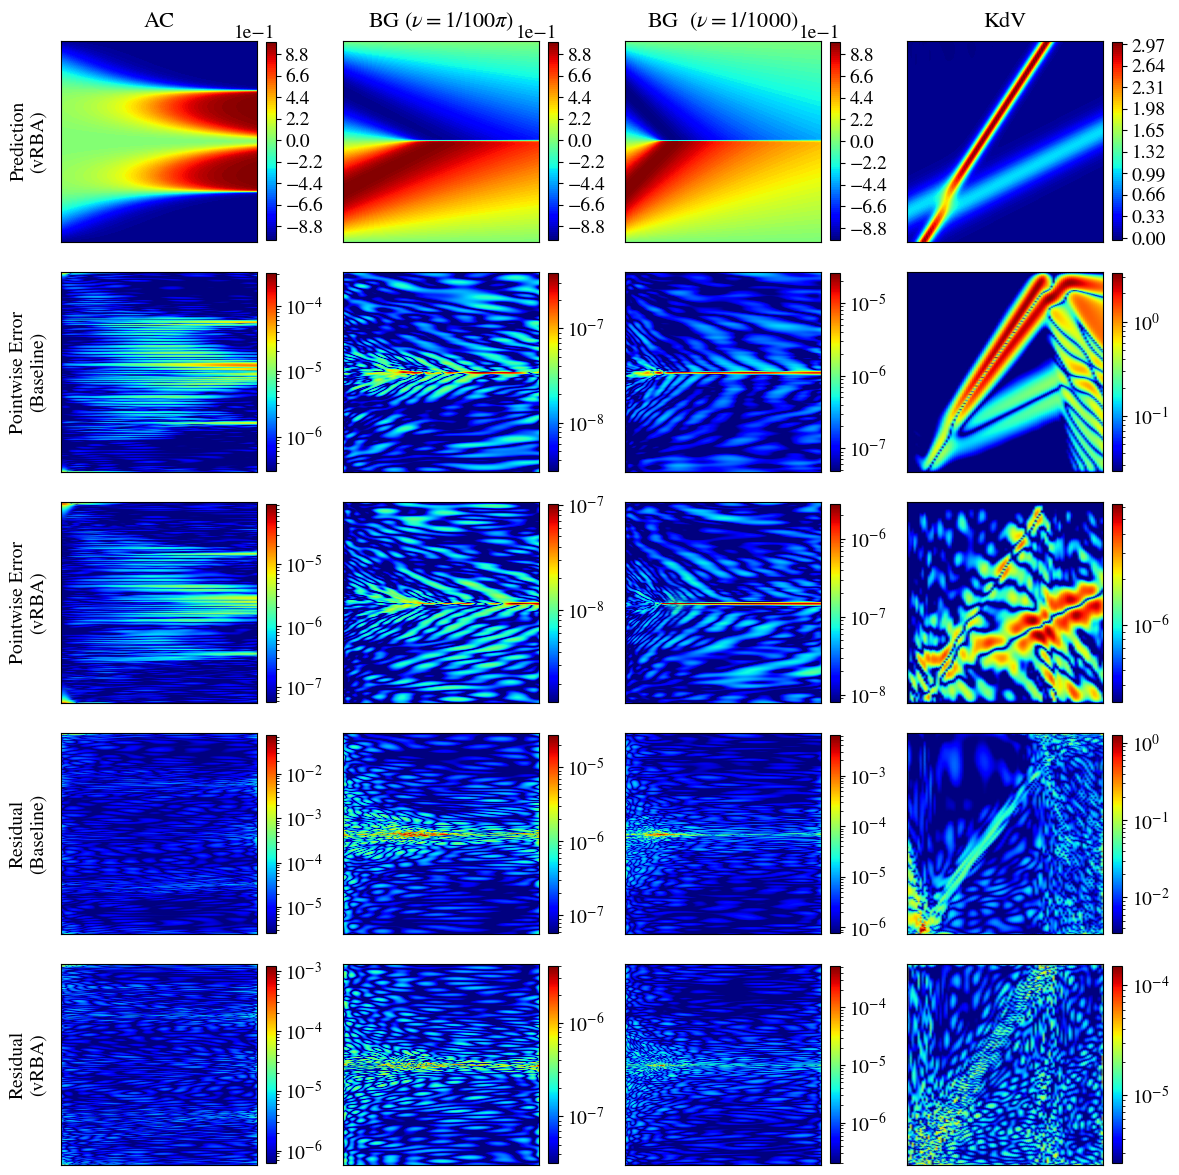

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import os

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration ---
BASE_DIR = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'

METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

EXAMPLES = {
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'AC'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG $(\nu= 1/100\pi) $'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG  $(\nu= 1/1000) $'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}

COL_ORDER = ['AC', 'BG_100pi', 'BG_1000', 'KdV']

# --- 3. Robust Data Loading ---
def load_data_package(example_key, method):
    ex_config = EXAMPLES[example_key]
    path = os.path.join(BASE_DIR, ex_config['dir'], ex_config['file_fmt'].format(method))
    
    if not os.path.exists(path):
        return None

    try:
        data = np.load(path)
        keys = list(data.keys())
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None
    
    # --- A. Fields ---
    T, X = None, None
    Exact, Pred, Resid = None, None, None
    
    # Grid
    if 't' in keys and 'x' in keys:
        if data['t'].ndim == 1:
            T, X = np.meshgrid(data['t'], data['x'], indexing='ij') 
        else:
             T, X = data['t'], data['x']
    elif 'T' in keys and 'X' in keys:
        T, X = data['T'], data['X']

    # Solution
    if 'u_exact' in keys: Exact = data['u_exact']
    elif 'u_ref' in keys: Exact = data['u_ref']
    elif 'Exact' in keys: Exact = data['Exact']
    
    if 'u' in keys: Pred = data['u']
    elif 'u_pred' in keys: Pred = data['u_pred']
    elif 'Pred' in keys: Pred = data['Pred']
    
    # Residual
    for k in ['res_grid', 'residual_field', 'f', 'f_pred', 'F', 'residual', 'res']:
        if k in keys: Resid = data[k]; break

    # Align Shapes
    if T is not None:
        target_shape = T.shape
        def align(arr):
            if arr is None: return None
            if arr.shape == target_shape: return arr
            if arr.T.shape == target_shape: return arr.T
            return arr 
        Exact = align(Exact)
        Pred  = align(Pred)
        Resid = align(Resid)

    # --- B. History (For unstable check) ---
    h_l2, h_linf = None, None

    for k in keys:
        if ('error' in k.lower() or 'l2' in k.lower()) and ('hist' in k.lower()):
            h_l2 = data[k]; break
            
    for k in keys:
        if ('linf' in k.lower()) and ('hist' in k.lower()):
            h_linf = data[k]; break

    return {
        'T': T, 'X': X, 
        'Exact': Exact, 'Pred': Pred, 'Res': Resid,
        'hist_l2': h_l2, 'hist_linf': h_linf,
        'method_name': method
    }

def stabilize_package(pkg):
    if pkg is None: return None
    
    Exact = pkg['Exact']
    Pred = pkg['Pred']
    
    f_l2 = np.inf
    if Exact is not None and Pred is not None:
        ref_norm = np.linalg.norm(Exact)
        f_l2 = np.linalg.norm(Exact - Pred) / ref_norm if ref_norm > 1e-16 else np.inf
    
    pkg['computed_l2'] = f_l2
    
    # If unstable (L2 > 1.0), check history
    if f_l2 > 1.0 and pkg['hist_linf'] is not None:
        try:
             best_idx = np.nanargmin(pkg['hist_linf'])
             if pkg['hist_l2'] is not None and best_idx < len(pkg['hist_l2']):
                 pkg['computed_l2'] = pkg['hist_l2'][best_idx]
        except:
            pass
            
    return pkg

# --- 4. Selection Logic ---
def get_comparison_data(ex_key):
    print(f"\n--- Analyzing {ex_key} ---")
    
    # 1. Baseline
    baseline_pkg = load_data_package(ex_key, 'linear')
    baseline_pkg = stabilize_package(baseline_pkg)
    
    # 2. Best Method
    candidates = []
    for method in METHODS:
        pkg = load_data_package(ex_key, method)
        pkg = stabilize_package(pkg)
        if pkg is None: continue
        candidates.append(pkg)

    if not candidates: return baseline_pkg, None

    candidates.sort(key=lambda x: x['computed_l2'])
    best_pkg = candidates[0]
    
    print(f"Baseline L2: {baseline_pkg['computed_l2']:.2e}")
    print(f"Winner: {best_pkg['method_name']} (L2: {best_pkg['computed_l2']:.2e})")
    
    return baseline_pkg, best_pkg

# --- 5. Helper: Individual Norm Calculation ---
def get_individual_norm(field):
    """
    Computes a LogNorm strictly for this single field.
    vmin = median(field)
    vmax = max(field)
    """
    if field is None:
        return None
        
    vals = np.abs(field)
    valid = vals[vals > 1e-16]
    
    if len(valid) == 0:
        return colors.LogNorm(vmin=1e-6, vmax=1e-5)
    
    vmin = np.median(valid)/2
    vmax = np.max(valid)
    
    # Safety to ensure vmin < vmax
    if vmax <= vmin:
        vmax = vmin * 10
        
    return colors.LogNorm(vmin=vmin, vmax=vmax)

# --- 6. Plotting Routine ---
def create_heatmap_grid():
    # 5 Rows: Prediction, Err(Base), Err(Best), Res(Base), Res(Best)
    fig, axes = plt.subplots(5, 4, figsize=(12, 12))
    
    row_titles = [
        'Prediction\n(vRBA)', 
        'Pointwise Error\n(Baseline)', 
        'Pointwise Error\n(vRBA)', 
        'Residual\n(Baseline)', 
        'Residual\n(vRBA)'
    ]

    for j, ex_key in enumerate(COL_ORDER):
        base_pkg, best_pkg = get_comparison_data(ex_key)
        
        # Grid Setup
        T, X = None, None
        if best_pkg and best_pkg['T'] is not None:
            T, X = best_pkg['T'], best_pkg['X']
        elif base_pkg and base_pkg['T'] is not None:
            T, X = base_pkg['T'], base_pkg['X']
        
        if T is None: continue

        # --- Prepare Fields ---
        # 1. Prediction (Best)
        pred_best = best_pkg['Pred'] if best_pkg else None
        
        # 2. Errors
        err_base, err_best = None, None
        if base_pkg and base_pkg['Exact'] is not None and base_pkg['Pred'] is not None:
            err_base = np.abs(base_pkg['Exact'] - base_pkg['Pred'])
        if best_pkg and best_pkg['Exact'] is not None and best_pkg['Pred'] is not None:
            err_best = np.abs(best_pkg['Exact'] - best_pkg['Pred'])
            
        # 3. Residuals
        res_base = base_pkg['Res'] if base_pkg else None
        res_best = best_pkg['Res'] if best_pkg else None

        # --- Plotting Function (Calculates Norm Internally) ---
        def plot_cell(ax_idx, field, cmap='jet', is_log=True):
            ax = axes[ax_idx, j]
            
            # Remove Ticks and Labels inside the plot
            ax.set_xticks([])
            ax.set_yticks([])
            
            if field is None:
                ax.text(0.5, 0.5, "No Data", ha='center')
                return

            if is_log:
                # Calculate Norm SPECIFIC to this field
                norm = get_individual_norm(field)
                pcm = ax.pcolormesh(T, X, np.abs(field), norm=norm, cmap=cmap, shading='gouraud')
            else:
                pcm = ax.contourf(T, X, field, levels=100, cmap=cmap)

            # Colorbar
            cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
            if not is_log:
                cbar.formatter.set_powerlimits((0, 0))
            
            # Row Labels (Y-Label of far-left plot only)
            if j == 0:
                ax.set_ylabel(row_titles[ax_idx], rotation=90, labelpad=10, fontsize=14)

            # Column Title (Top only)
            if ax_idx == 0:
                ax.set_title(EXAMPLES[ex_key]['name'], fontsize=16, pad=10)

        # --- Execute Plots ---
        # Row 0: Prediction (Linear scale)
        plot_cell(0, pred_best, cmap='jet', is_log=False)
        
        # Row 1: Error Baseline (Individual Log Norm)
        plot_cell(1, err_base, cmap='jet', is_log=True)
        
        # Row 2: Error Best (Individual Log Norm)
        plot_cell(2, err_best, cmap='jet', is_log=True)
        
        # Row 3: Residual Baseline (Individual Log Norm)
        plot_cell(3, res_base, cmap='jet', is_log=True)
        
        # Row 4: Residual Best (Individual Log Norm)
        plot_cell(4, res_best, cmap='jet', is_log=True)

    plt.tight_layout()
    plt.savefig('All_results_PINN.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    create_heatmap_grid()

In [10]:
import numpy as np
import os

# --- 1. Configuration ---
BASE_DIR = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'

METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

EXAMPLES = {
    'AC_1st_order':       {'dir': 'AC_1st_order',       'file_fmt': 'results_{}.npz',       'name': 'Allen-Cahn'},
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'Allen-Cahn'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'Burgers (1/100pi)'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'Burgers (1/1000)'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}

COL_ORDER = ['AC_1st_order','AC', 'BG_100pi', 'BG_1000', 'KdV']

# --- 2. Robust Data Loading ---
def load_data_package(example_key, method):
    ex_config = EXAMPLES[example_key]
    path = os.path.join(BASE_DIR, ex_config['dir'], ex_config['file_fmt'].format(method))
    
    if not os.path.exists(path):
        return None

    try:
        data = np.load(path)
        keys = list(data.keys())
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None
    
    # --- A. Fields ---
    Exact, Pred, Resid = None, None, None
    
    # Solution
    if 'u_exact' in keys: Exact = data['u_exact']
    elif 'u_ref' in keys: Exact = data['u_ref']
    elif 'Exact' in keys: Exact = data['Exact']
    
    if 'u' in keys: Pred = data['u']
    elif 'u_pred' in keys: Pred = data['u_pred']
    elif 'Pred' in keys: Pred = data['Pred']
    
    # Residual
    for k in ['res_grid', 'residual_field', 'f', 'f_pred', 'F', 'residual', 'res']:
        if k in keys: Resid = data[k]; break

    # Align Shapes (Flatten for metric calculation if needed, but norm works on arrays)
    if Exact is not None and Pred is not None:
        if Exact.shape != Pred.shape:
             if Exact.T.shape == Pred.shape: Exact = Exact.T

    # --- B. History (For unstable check) ---
    h_l2, h_linf, h_var = None, None, None

    # L2 History
    for k in keys:
        if ('error' in k.lower() or 'l2' in k.lower()) and ('hist' in k.lower()):
            h_l2 = data[k]; break
            
    # Linf History
    for k in keys:
        if ('linf' in k.lower()) and ('hist' in k.lower()):
            h_linf = data[k]; break
            
    # Variance History (Optional)
    for k in keys:
        if ('var' in k.lower()) and ('hist' in k.lower()):
            h_var = data[k]; break

    return {
        'Exact': Exact, 'Pred': Pred, 'Res': Resid,
        'hist_l2': h_l2, 'hist_linf': h_linf, 'hist_var': h_var,
        'method_name': method
    }

def calculate_metrics(pkg):
    if pkg is None: return None
    
    Exact = pkg['Exact']
    Pred = pkg['Pred']
    Res = pkg['Res']
    
    # 1. Base Metrics from Fields
    f_l2 = np.inf
    f_linf = np.inf
    f_var = np.inf
    
    if Exact is not None and Pred is not None:
        ref_norm = np.linalg.norm(Exact)
        f_l2 = np.linalg.norm(Exact - Pred) / ref_norm if ref_norm > 1e-16 else np.inf
        
    if Res is not None:
        f_linf = np.max(np.abs(Res))
        f_var = np.var(Res)
        
    # 2. Stability Check (Use History if Unstable)
    final_l2 = f_l2
    final_linf = f_linf
    final_var = f_var
    source = "Field"
    
    # If L2 is exploded (> 1.0) or NaN, check history for the best epoch
    if f_l2 > 1.0 or np.isnan(f_l2):
        if pkg['hist_linf'] is not None and len(pkg['hist_linf']) > 0:
            try:
                # Find index where Residual L_inf was lowest (usually best model checkpoint)
                best_idx = np.nanargmin(pkg['hist_linf'])
                
                if pkg['hist_l2'] is not None and best_idx < len(pkg['hist_l2']):
                    final_l2 = pkg['hist_l2'][best_idx]
                    final_linf = pkg['hist_linf'][best_idx]
                    
                    if pkg['hist_var'] is not None and best_idx < len(pkg['hist_var']):
                        final_var = pkg['hist_var'][best_idx]
                    else:
                        final_var = np.nan
                    source = f"Hist[{best_idx}]"
            except:
                pass

    return {
        'method': pkg['method_name'],
        'l2': final_l2,
        'linf': final_linf,
        'var': final_var,
        'source': source
    }

# --- 3. Analysis Routine ---
def run_analysis_table():
    
    for ex_key in COL_ORDER:
        print(f"\n=====================================================================================")
        print(f"  ANALYSIS FOR: {EXAMPLES[ex_key]['name']}")
        print(f"=====================================================================================")
        print(f"{'Method':<15} | {'Rel L2 Error':<15} | {'Res L_inf':<15} | {'Res Var':<15} | {'Source'}")
        print("-" * 85)
        
        candidates = []
        
        for method in METHODS:
            pkg = load_data_package(ex_key, method)
            if pkg is None:
                # print(f"{method:<15} | {'--':<15} | {'--':<15} | {'--':<15} | File Not Found")
                continue
            
            metrics = calculate_metrics(pkg)
            
            # Formatting
            l2_str = f"{metrics['l2']:.2e}" if metrics['l2'] != np.inf else "N/A"
            linf_str = f"{metrics['linf']:.2e}" if metrics['linf'] != np.inf else "N/A"
            var_str = f"{metrics['var']:.2e}" if metrics['var'] != np.inf and not np.isnan(metrics['var']) else "N/A"
            
            print(f"{method:<15} | {l2_str:<15} | {linf_str:<15} | {var_str:<15} | {metrics['source']}")
            
            candidates.append(metrics)
            
        if candidates:
            # Determine Winner (Lowest L2)
            candidates.sort(key=lambda x: x['l2'])
            winner = candidates[0]
            print("-" * 85)
            print(f"WINNER: {winner['method']} (L2: {winner['l2']:.2e})")
            
            # Check baseline
            baseline = next((x for x in candidates if x['method'] == 'linear'), None)
            if baseline:
                print(f"BASELINE (Linear): {baseline['l2']:.2e}")
                if baseline['l2'] > 0:
                    improv = baseline['l2'] / winner['l2']
                    print(f"IMPROVEMENT: {improv:.1f}x")

if __name__ == "__main__":
    run_analysis_table()


  ANALYSIS FOR: Allen-Cahn
Method          | Rel L2 Error    | Res L_inf       | Res Var         | Source
-------------------------------------------------------------------------------------
linear          | 1.98e-03        | 1.22e-01        | 1.73e-06        | Field


exponential     | 4.39e-04        | 5.00e-02        | 2.44e-07        | Field
quadratic       | 4.68e-04        | 8.42e-02        | 6.07e-07        | Field
-------------------------------------------------------------------------------------
WINNER: exponential (L2: 4.39e-04)
BASELINE (Linear): 1.98e-03
IMPROVEMENT: 4.5x

  ANALYSIS FOR: Allen-Cahn
Method          | Rel L2 Error    | Res L_inf       | Res Var         | Source
-------------------------------------------------------------------------------------
linear          | 8.97e-06        | 7.68e-02        | 1.95e-07        | Field
exponential     | 2.50e-06        | 1.35e-02        | 1.55e-09        | Field
quadratic       | 1.88e-06        | 1.22e-03        | 3.15e-11        | Field
logarithmic     | 4.94e-06        | 1.77e-02        | 3.42e-09        | Field
lp              | 7.40e-06        | 3.63e-03        | 2.38e-10        | Field
superexp        | 3.61e-06        | 3.26e-02        | 1.21e-08        | Field
cosh            